In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal
%matplotlib inline

##Import Reference Data

In [7]:
df_R = pd.read_csv(filepath_or_buffer = 'data/CompleteCal_shift.csv', parse_dates = [0], index_col = 0)
print df_R[:5]

                     CO_ppm  NO_ppb  NO2_ppb  O3_ppb
Date                                                
2014-07-07 07:13:00     0.2     1.1     13.4      28
2014-07-07 07:14:00     0.3     1.2     13.8      28
2014-07-07 07:15:00     0.3     1.2     14.4      26
2014-07-07 07:16:00     0.3     1.3     14.9      25
2014-07-07 07:17:00     0.3     7.8     17.9      24


##Import Pod Data

In [30]:
df_P = pd.io.parsers.read_csv(filepath_or_buffer = 'data/F5_field_clean.csv', parse_dates = [0], index_col = 0)
print df_P[:5]

                       UnixTime  e2v03  Temp    Rh  Unnamed: 43
YYYY/MM/DD_HH:MM:SS                                            
2014-07-22 00:00:03  1405987203     30  37.7  16.0            0
2014-07-22 00:00:10  1405987210     30  37.8  15.9            0
2014-07-22 00:00:19  1405987219     30  37.8  16.1            0
2014-07-22 00:00:27  1405987227     30  37.9  15.8            0
2014-07-22 00:00:35  1405987235     30  37.8  15.3            0


###Resample all of the data, so that the reference and pod data are in the same dataframe, and also average over a specified time.

In [11]:
resamp_time = '1Min'

In [31]:
#df_all = pd.concat([df_R.O3_ppb.resample(resamp_time), df_P.resample(resamp_time)], axis=1).dropna()
df_all = df_P.resample(resamp_time).dropna()
print df_all[:5]

                         UnixTime      e2v03       Temp         Rh  \
YYYY/MM/DD_HH:MM:SS                                                  
2014-07-22 00:00:00  1.405987e+09  29.625000  37.812500  15.675000   
2014-07-22 00:01:00  1.405987e+09  29.857143  37.900000  15.771429   
2014-07-22 00:02:00  1.405987e+09  29.142857  37.771429  15.257143   
2014-07-22 00:03:00  1.405987e+09  28.875000  37.850000  14.900000   
2014-07-22 00:04:00  1.405987e+09  29.000000  38.114286  15.314286   

                     Unnamed: 43  
YYYY/MM/DD_HH:MM:SS               
2014-07-22 00:00:00            0  
2014-07-22 00:01:00            0  
2014-07-22 00:02:00            0  
2014-07-22 00:03:00            0  
2014-07-22 00:04:00            0  


####Create 'days since start' feature.

In [32]:
df_all['days from start'] = df_all['UnixTime']
for i in range(0,len(df_all['UnixTime'])):
    df_all['days from start'][i] = int(df_all['UnixTime'][i]- df_all['UnixTime'][0])/86400

####Drop the names from all of the data to prepare it for filtering

In [33]:
df_fit = df_all.dropna()

In [34]:
rh_sm = None
temp_sm = None
ref_o3_sm = None
pod_o3_sm = None

#Declare the data column to filter.

#Filtering

####Define functions to plot the raw and filtered data

In [22]:
def plot_data(data, title):
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111)
    ax.plot(data, marker = '.')
    ax.set_title(title)

####Define a function that filters the data.

In [23]:
def plot_filter(b):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = ax1.twinx()

    w, h = signal.freqz(b)
    w /= np.pi
    ax1.plot(w, 20 * np.log10(abs(h)), 'r-')
    ax2.plot(w[1:], -np.diff(np.unwrap(np.angle(h))), 'b-')
    ax2.set_ylim(bottom=0.)

    ax3 = fig.add_subplot(212)
    ax3.plot(w, 20 * abs(h), 'r-')

In [24]:
def hanning_window_fir_filtering(data_points, filter_minutes, y_data):
    #make a window (finite-impulse response method), 
    #second agrment is frequency in units where 1 is sampling frequency (1 means 1 cycle per minute, 0.2 is equal to a period of 5 minutes) 
    #first agrument is how many data points are in the window (frequency resolution) if you choose 100, there is a time delay by 50 data points
    samp_freq = 1.0/filter_minutes
    b = signal.firwin(data_points, samp_freq, window='hanning')
    
    impulse = np.zeros((100,))
    impulse[0] = 1.

    #replace impulse with my y values
    y = signal.lfilter(b, 1., y_data)
    
    #call the plotting functions for the filtered and raw data.
    plot_data(y_data,'Raw Data')
    plot_data(y,'Filtered Data')    
    
    #Call the impulse plotting function
    plot_filter(b)
    
    #Delete the shifted points from the new data
    y_final = np.delete(y, list(xrange(data_points)))
    
    return y_final

####Call the filtering function

Pod Data
[ 31.65535414  31.68264243  31.70154347  31.67121401  31.56343931]


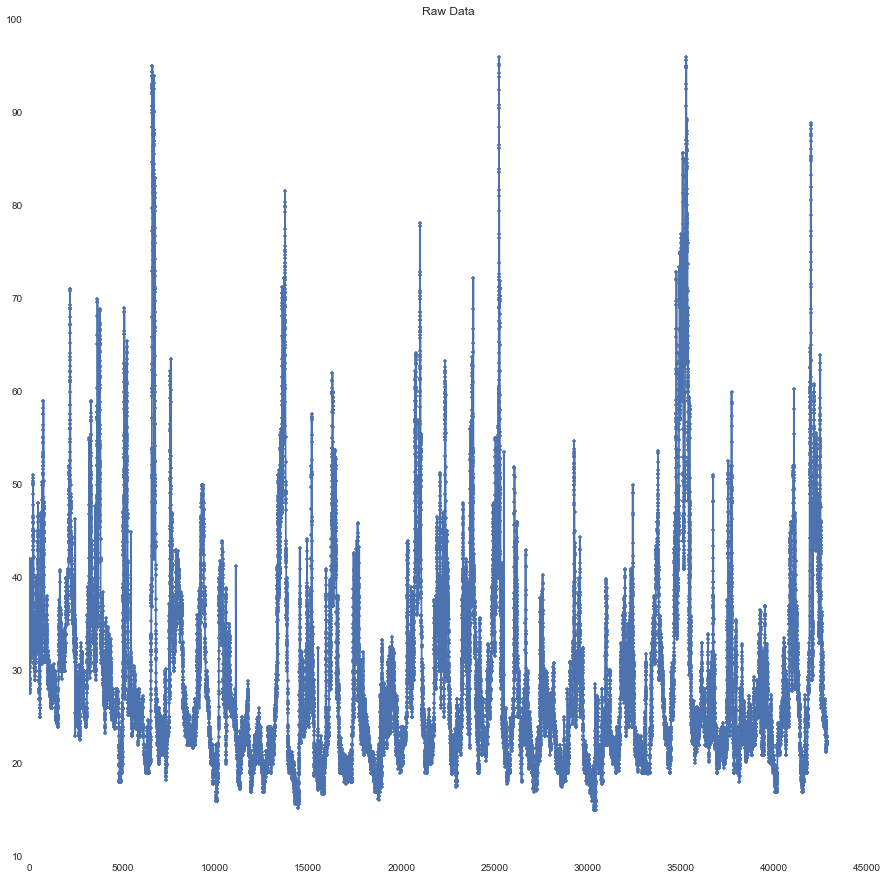

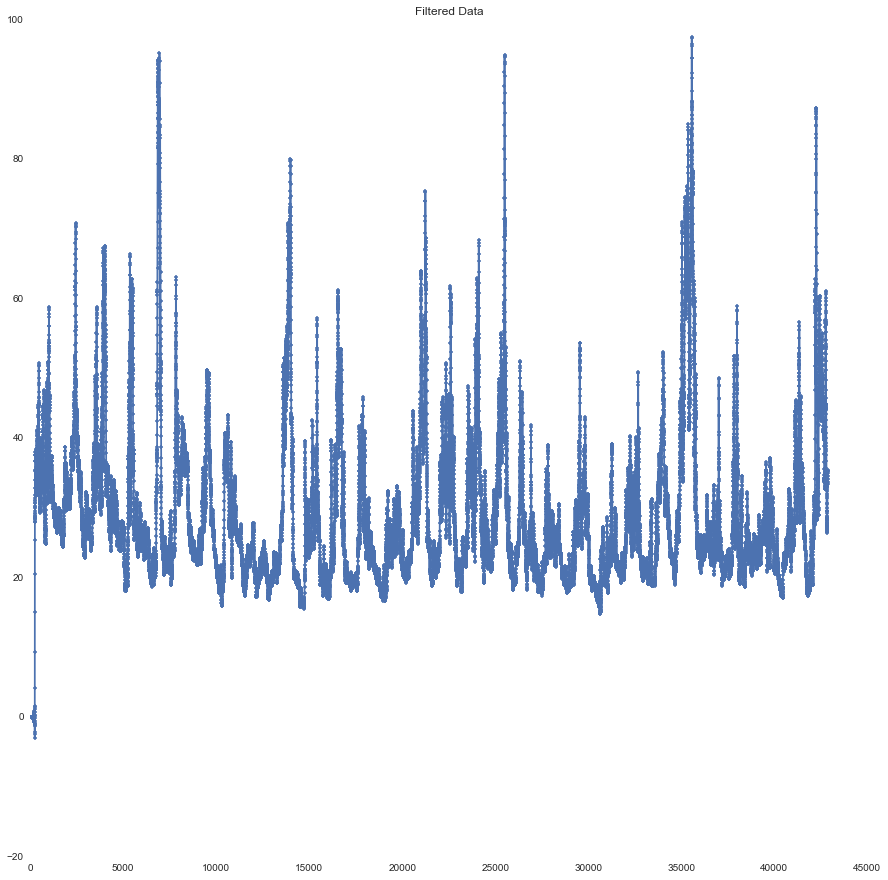

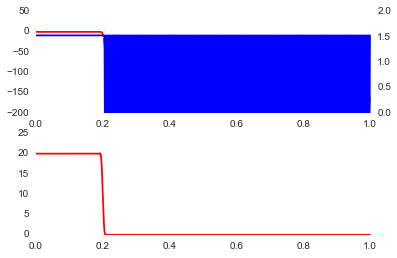

In [35]:
#Choose the number of data points in the window, and the number of minutes in the sampling period.
data_points = 500
filter_minutes = 5

#ref_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['O3_ppb'].values)
#print 'Reference Data'
#print ref_o3_sm[:25]

pod_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['e2v03'].values)
print 'Pod Data'

print pod_o3_sm[:5]

####Make a new dataframe without the offset rows, and append the new data into it.

In [27]:
df_short = df_fit.ix[data_points:]
print df_short[:5]

                     O3_ppb      UnixTime  e2v03       Temp         Rh  \
Date                                                                     
2014-08-14 01:42:00      45  1.407981e+09     19  27.214286  28.757143   
2014-08-14 01:43:00      45  1.407981e+09     19  27.257143  28.828571   
2014-08-14 01:44:00      45  1.407981e+09     19  27.200000  28.937500   
2014-08-14 01:45:00      45  1.407981e+09     19  27.171429  28.985714   
2014-08-14 01:46:00      45  1.407981e+09     19  27.100000  28.928571   

                     Unnamed: 43  days from start  
Date                                               
2014-08-14 01:42:00    53.571429                0  
2014-08-14 01:43:00    48.857143                0  
2014-08-14 01:44:00    49.625000                0  
2014-08-14 01:45:00    50.000000                0  
2014-08-14 01:46:00    62.285714                0  


In [14]:
df_short['ref_o3_smooth'] = ref_o3_sm
#df_short['pod_o3_smooth'] = pod_o3_sm
print df_short[:25]

                     O3_ppb      UnixTime      e2v03       Temp         Rh  \
Date                                                                         
2014-07-13 04:40:00      27  1.405226e+09  81.875000  22.612500  62.050000   
2014-07-13 04:41:00      27  1.405226e+09  81.142857  22.614286  62.328571   
2014-07-13 04:42:00      27  1.405227e+09  81.000000  22.612500  62.200000   
2014-07-13 04:43:00      27  1.405227e+09  80.142857  22.657143  62.300000   
2014-07-13 04:44:00      28  1.405227e+09  79.875000  22.675000  62.037500   
2014-07-13 04:45:00      28  1.405227e+09  79.000000  22.700000  61.885714   
2014-07-13 04:46:00      27  1.405227e+09  79.500000  22.700000  61.750000   
2014-07-13 04:47:00      28  1.405227e+09  78.714286  22.700000  61.528571   
2014-07-13 04:48:00      30  1.405227e+09  76.125000  22.675000  61.362500   
2014-07-13 04:49:00      31  1.405227e+09  74.875000  22.650000  61.400000   
2014-07-13 04:50:00      31  1.405227e+09  75.000000  22.642857 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipython-3.1.0-py2.7.egg/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


##Make a csv file with the smoothed data

In [15]:
df_short.to_csv(path_or_buf = 'data/N4_filt_all.csv')